In [1]:
# importing essential libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [2]:
# reading dataset

diamond = pd.read_csv(r"E:\PROJECT\Diamond\data\Diamond.csv")

In [3]:
diamond.head()

,cut,color,clarity,carat,depth,table,price,x (Premium),z (Very Good),y (Good)
0,Fair,E,VS2,0.22,65.1,61.0,337,3.87,2.49,3.78
1,Fair,E,SI2,0.86,55.1,69.0,2757,6.45,3.52,6.33
2,Fair,F,SI2,0.96,66.3,62.0,2759,6.27,4.07,5.95
3,Fair,F,VS2,0.70,64.5,57.0,2762,5.57,3.58,5.53
4,Fair,F,VS2,0.70,65.3,55.0,2762,5.63,3.66,5.58


In [4]:
diamond.shape

(53940, 10)

In [5]:
# checking for duplicates

diamond.duplicated().sum()

146

In [6]:
# removing duplicates

diamond = diamond.drop_duplicates()

In [7]:
diamond.duplicated().sum()

0

In [8]:
# checking for null values

diamond.isnull().sum()

cut              0
color            0
clarity          0
carat            0
depth            0
table            0
price            0
x (Premium)      0
z (Very Good)    0
y (Good)         0
dtype: int64

In [9]:
# taking only required columns from dataset

diamond= diamond[['cut', 'clarity', 'color', 'carat', 'price']]

In [10]:
diamond.color.value_counts()

color
G    11262
E     9776
F     9520
H     8272
D     6755
I     5407
J     2802
Name: count, dtype: int64

In [11]:
diamond.head()

,cut,clarity,color,carat,price
0,Fair,VS2,E,0.22,337
1,Fair,SI2,E,0.86,2757
2,Fair,SI2,F,0.96,2759
3,Fair,VS2,F,0.70,2762
4,Fair,VS2,F,0.70,2762


In [12]:
diamond.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53794 entries, 0 to 53939
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cut      53794 non-null  object 
 1   clarity  53794 non-null  object 
 2   color    53794 non-null  object 
 3   carat    53794 non-null  float64
 4   price    53794 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 2.5+ MB


In [13]:
diamond.describe()

,carat,price
count,53794.00000,53794.000000
mean,0.79778,3933.065082
std,0.47339,3988.114460
min,0.20000,326.000000
25%,0.40000,951.000000
50%,0.70000,2401.000000
75%,1.04000,5326.750000
max,5.01000,18823.000000


In [14]:
diamond['clarity'].value_counts()

clarity
SI1     13032
VS2     12229
SI2      9150
VS1      8156
VVS2     5056
VVS1     3647
IF       1784
I1        740
Name: count, dtype: int64

In [15]:
# initializing X variable

X = diamond.drop(columns='price', axis=1)

In [16]:
# initializing y variable

y= diamond[['price']]

In [17]:
# Define which columns should be ordinal-encoded and which should be scaled

cat_columns = X.select_dtypes(include='object').columns
num_columns = X.select_dtypes(exclude='object').columns
            
# Define the custom ranking for each ordinal variable
cut_categories = ['Fair', 'Good', 'Very Good','Premium','Ideal']
color_categories = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity_categories = ['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF']

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder,StandardScaler

# Numerical Pipeline
num_pipeline = Pipeline(
                steps = [
                ('imputer',SimpleImputer(strategy='median')),
                ('scaler',StandardScaler())                
                ]
            )

# Categorical Pipeline
cat_pipeline = Pipeline(
                steps=[
                ('imputer',SimpleImputer(strategy='most_frequent')),
                ('ordinal_encoder',OrdinalEncoder(categories=[cut_categories,color_categories,clarity_categories],handle_unknown='use_encoded_value', unknown_value=-1)),
                ('scaler',StandardScaler())
                ]
            )

preprocessor = ColumnTransformer(
                [
                ('num_pipeline',num_pipeline,num_columns),
                ('cat_pipeline',cat_pipeline,cat_columns)
                ]
            )

In [18]:
# initializing train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [19]:
# transforming data with pipeline

X_train = pd.DataFrame(preprocessor.fit_transform(X_train),columns=preprocessor.get_feature_names_out())
X_test = pd.DataFrame(preprocessor.transform(X_test),columns=preprocessor.get_feature_names_out())

In [20]:
preprocessor.get_feature_names_out()

array(['num_pipeline__carat', 'cat_pipeline__cut',
       'cat_pipeline__clarity', 'cat_pipeline__color'], dtype=object)

In [21]:
#creating function for all metrics after model training

def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [22]:
# training regressor models to find best model

models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train.values.flatten()) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 1518.2533
- Mean Absolute Error: 990.5358
- R2 Score: 0.8550
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1537.4904
- Mean Absolute Error: 1000.0512
- R2 Score: 0.8517


Lasso
Model performance for Training set
- Root Mean Squared Error: 1518.2541
- Mean Absolute Error: 990.2922
- R2 Score: 0.8550
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1537.4532
- Mean Absolute Error: 999.7908
- R2 Score: 0.8517


Ridge
Model performance for Training set
- Root Mean Squared Error: 1518.2533
- Mean Absolute Error: 990.5189
- R2 Score: 0.8550
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1537.4875
- Mean Absolute Error: 1000.0327
- R2 Score: 0.8517


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 1442.7050
- Mean Absolute Error: 815.4152
- R2 

In [23]:
# getting results

pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
7,CatBoosting Regressor,0.881237
6,XGBRegressor,0.881072
5,Random Forest Regressor,0.877918
4,Decision Tree,0.875419
3,K-Neighbors Regressor,0.861803
1,Lasso,0.851734
2,Ridge,0.851728
0,Linear Regression,0.851727
8,AdaBoost Regressor,0.831139


In [24]:
# hyperparameter tuning for XGBOOST MODEL

xgb = XGBRegressor()

# Parameters
params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ],
 'n_estimators':[300,400,500,600]
}

rs_xgb=RandomizedSearchCV(xgb,param_distributions=params,scoring='r2',n_jobs=-1,cv=5)
rs_xgb.fit(X_train, y_train.values.flatten())

# Print the tuned parameters and score
print(rs_xgb.best_params_)
print(rs_xgb.best_score_)

{'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.0, 'colsample_bytree': 0.5}
0.8819055438041687


In [25]:
def print_evaluated_results(model,X_train,y_train,X_test,y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    # Printing results
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))

In [26]:
# Selecting best xgb model
best_xgb = rs_xgb.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_xgb,X_train,y_train,X_test,y_test)

Model performance for Training set
- Root Mean Squared Error: 1363.3512
- Mean Absolute Error: 783.1348
- R2 Score: 0.8831
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1372.4522
- Mean Absolute Error: 784.9255
- R2 Score: 0.8819


num_pipeline__carat      0.980408
cat_pipeline__cut        0.019592
cat_pipeline__clarity    0.000000
cat_pipeline__color      0.000000
dtype: float32




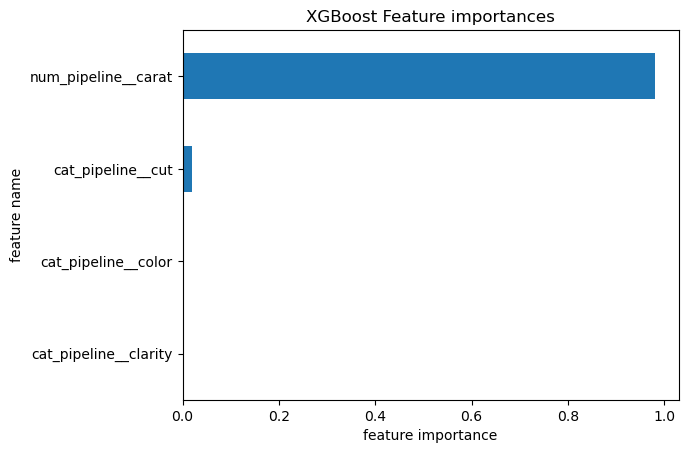

In [27]:
feature_imp = best_xgb.feature_importances_
feature_nm = best_xgb.feature_names_in_
imp_series = pd.Series(feature_imp)
imp_series.index = feature_nm
print(imp_series.sort_values(ascending=False))
print('\n')
imp_series.sort_values().plot(kind='barh',
                              xlabel='feature importance',
                              ylabel='feature name',
                              title='XGBoost Feature importances')
plt.show()